# Seminární práce z předmětu Počítačové zpracování signálu (KI/PZS)
**Téma:** 1. Výpočet tepové frekvence z EKG signálu

**Autor:** Karel Murgač

## Zadání
Cílem této části je navrhnout algoritmus pro automatickou detekci R-vrcholů v EKG signálu a výpočet tepové frekvence.
Algoritmus bude aplikován na databázi **DriveDB** (monitoring řidičů) a následně validován na databázi **MIT-BIH (NSRDB)**.

**Postup řešení:**
1. Načtení dat pomocí knihovny `wfdb`.
2. Detekce R-vrcholů (dominantních peaků) v signálu.
3. Výpočet tepové frekvence (BPM).
4. Vizualizace výsledků a zhodnocení úspěšnosti.

In [10]:
# !pip install wfdb scipy matplotlib numpy

import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os

# Nastavení grafů pro lepší čitelnost
plt.rcParams['figure.figsize'] = [15, 5]
print("Knihovny úspěšně načteny.")

Knihovny úspěšně načteny.


## 1. Návrh algoritmu pro detekci R-vrcholů

[cite_start]Podle zadání určuje vzdálenost R-vrcholů dobu mezi tepy. Tepová frekvence (Heart Rate - HR) se vypočítá jako počet těchto vrcholů za minutu.

Můj algoritmus využívá funkci `find_peaks` z knihovny `scipy`, která hledá lokální maxima. Abychom detekovali pouze R-vrcholy (a ne šum nebo vlnu T), nastavíme následující parametry:
* **Výška (height):** Ignorujeme vrcholy nižší než určitá hranice (např. 50 % maximální výchylky signálu).
* **Vzdálenost (distance):** Lidské srdce má fyzikální limit, jak rychle může tlouct. Nastavíme minimální rozestup mezi vrcholy (např. odpovídající tepu 200 BPM), aby nedošlo k dvojí detekci jednoho tepu.

Vzorec pro výpočet tepové frekvence z průměrného intervalu mezi vrcholy (RR interval):

$$HR = \frac{60}{\text{průměrný RR interval (s)}}$$

In [11]:
def analyzuj_ekg(signal, fs, nazev_zaznamu="Neznámý", vykreslit=False):
    """
    Robustní verze: Používá percentily pro určení orientace signálu.
    To zabrání chybám, když jeden velký artefakt zmate detekci.
    """
    
    # 1. Centralizace (dostaneme signál na nulu podle mediánu)
    signal_centered = signal - np.median(signal)

    # 2. Rozhodnutí o orientaci (Percentilová metoda)
    # Místo min/max koukáme na 1. a 99. percentil. 
    # To nám řekne, kde je "většina" energie signálu, aniž by nás zmátl jeden náhodný výkyv.
    p1 = np.percentile(signal_centered, 1)   # Hranice spodních 99 % dat
    p99 = np.percentile(signal_centered, 99) # Hranice horních 99 % dat
    
    # Pokud je "dno" hlubší než je "strop" vysoký, otočíme signál.
    if np.abs(p1) > np.abs(p99):
        signal_pro_detekci = -signal_centered
    else:
        signal_pro_detekci = signal_centered

    # 3. Nastavení prahu
    # Znovu použijeme percentil na (už správně otočeném) signálu
    robust_max = np.percentile(signal_pro_detekci, 99.5)
    
    # Práh: 40 % z výšky robustního maxima
    min_height = 0.4 * robust_max
    
    # Vzdálenost: min 0.3 sekundy mezi tepy
    min_distance = int(0.3 * fs) 
    
    # 4. Detekce
    r_peaks, _ = find_peaks(signal_pro_detekci, height=min_height, distance=min_distance)
    
    # 5. Výpočet BPM
    if len(r_peaks) > 1:
        rr_intervals = np.diff(r_peaks) / fs
        avg_rr = np.mean(rr_intervals)
        bpm = 60 / avg_rr
    else:
        bpm = 0

    # 6. Grafika
    if vykreslit:
        limit_vzorku = int(min(len(signal), 10 * fs))
        t = np.arange(limit_vzorku) / fs
        
        plt.figure(figsize=(12, 5))
        
        # Vykreslíme signál, na kterém proběhla detekce (měl by mít špičky NAHORU)
        plt.plot(t, signal_pro_detekci[:limit_vzorku], label='Upravený signál', color='steelblue')
        
        peaks_to_plot = r_peaks[r_peaks < limit_vzorku]
        plt.plot(peaks_to_plot / fs, signal_pro_detekci[peaks_to_plot], "x", color='red', markersize=10, label='Detekované R-vrcholy')
        
        plt.hlines(min_height, 0, t[-1], colors='green', linestyles='dashed', label='Práh')

        plt.title(f"Záznam: {nazev_zaznamu} | BPM: {bpm:.1f}")
        plt.xlabel("Čas [s]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    return bpm, r_peaks

## 2. Aplikace na databázi DriveDB

Nyní načteme 17 měření z databáze `drivedb`. Data mám stažená lokálně.
Pro každý soubor načteme signál, zjistíme vzorkovací frekvenci a aplikujeme naši funkci.

*Poznámka: Názvy souborů v databázi jsou obvykle ve formátu `drive01`, `drive02`, atd.*

Zpracovávám tyto záznamy: ['drive01', 'drive02', 'drive03', 'drive04', 'drive05', 'drive06', 'drive07', 'drive08', 'drive09', 'drive10', 'drive11', 'drive12', 'drive13', 'drive14', 'drive15', 'drive16', 'drive17a', 'drive17b']
Zpracování DriveDB...


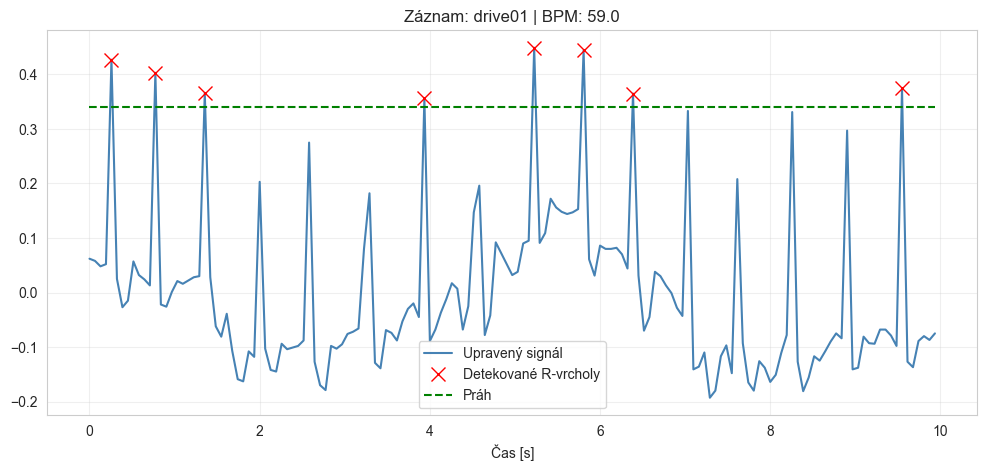

drive01: 59.03 BPM
drive02: 128.43 BPM
drive03: 74.25 BPM
drive04: 77.28 BPM
drive05: 0.00 BPM
drive06: 97.70 BPM
drive07: 83.17 BPM
drive08: 119.86 BPM
drive09: 118.30 BPM
drive10: 61.46 BPM
drive11: 111.10 BPM
drive12: 61.57 BPM
drive13: 92.61 BPM
drive14: 92.61 BPM
drive15: 116.46 BPM
drive16: 24.32 BPM
drive17a: 76.11 BPM
drive17b: 8.95 BPM


In [12]:
cesta_k_drivedb = 'data' 

# 1. Vytvoříme seznam pro drive01 až drive16
zaznamy_drive = [f"drive{i:02d}" for i in range(1, 17)]

# 2. Ručně přidáme drive17a a drive17b, protože drive17 neexistuje
zaznamy_drive.append("drive17a")
zaznamy_drive.append("drive17b")

vysledky_drive = []

print("Zpracovávám tyto záznamy:", zaznamy_drive)
print("Zpracování DriveDB...")

for nazev in zaznamy_drive:
    try:
        # Načtení záznamu (header i signál)
        # pn_dir=None znamená, že nehledáme na internetu, ale lokálně
        record = wfdb.rdrecord(os.path.join(cesta_k_drivedb, nazev))
        
        # Získání EKG signálu (obvykle první kanál, ale ověříme)
        # Signály jsou v record.p_signal
        # Názvy kanálů v record.sig_name
        
        index_ekg = -1
        for i, sig_name in enumerate(record.sig_name):
            # Hledáme kanál, který má v názvu 'ECG' nebo je to typický EKG
            if "ECG" in sig_name.upper() or "EKG" in sig_name.upper():
                index_ekg = i
                break
        
        if index_ekg == -1:
            # Pokud nenajde název, zkusíme vzít první kanál (často bývá EKG u drivedb)
            # Ale v drivedb může být i EMG, zkontroluj názvy kanálů printem: print(record.sig_name)
            index_ekg = 0 
            
        signal = record.p_signal[:, index_ekg]
        fs = record.fs # Vzorkovací frekvence
        
        # Analýza (vykreslíme jen první záznam pro kontrolu)
        ukazat_graf = (nazev == "drive01") 
        bpm, _ = analyzuj_ekg(signal, fs, nazev_zaznamu=nazev, vykreslit=ukazat_graf)
        
        vysledky_drive.append((nazev, bpm))
        print(f"{nazev}: {bpm:.2f} BPM")
        
    except Exception as e:
        print(f"Chyba při zpracování {nazev}: {e}")


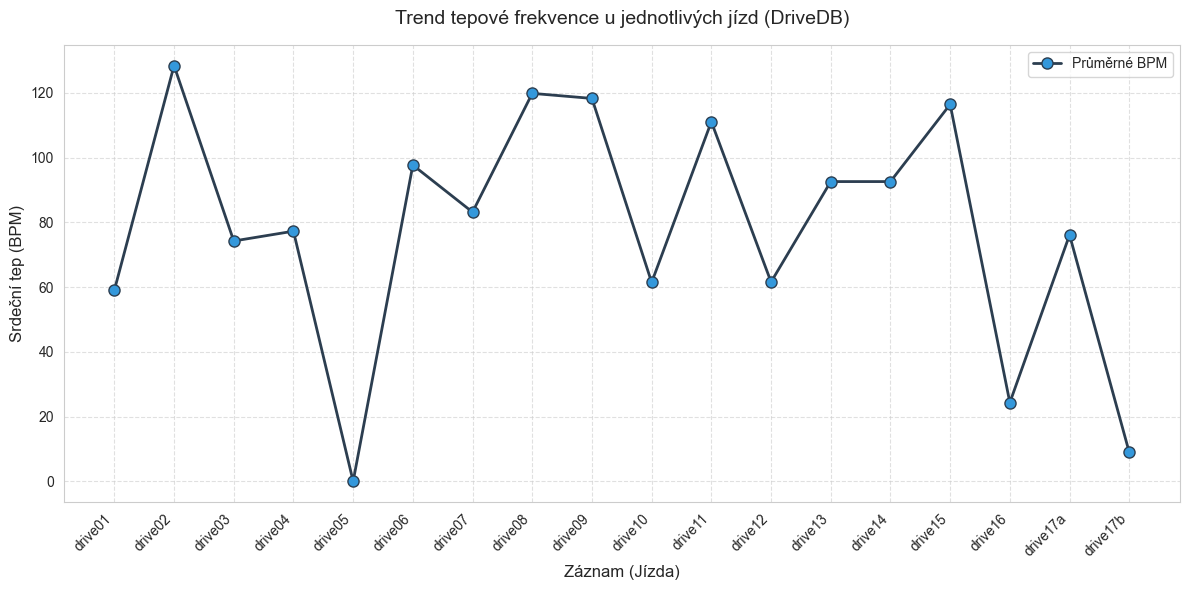

In [13]:
# --- Vykreslení souhrnného grafu BPM (ČÁROVÝ GRAF) ---
nazvy = [x[0] for x in vysledky_drive]
hodnoty = [x[1] for x in vysledky_drive]

plt.figure(figsize=(12, 6))

# Vykreslení čáry se značkami ('-o' vytvoří čáru i body)
plt.plot(nazvy, hodnoty, marker='o', linestyle='-', color='#2c3e50', 
         linewidth=2, markersize=8, markerfacecolor='#3498db', label='Průměrné BPM')

# Přidání vodorovné čáry pro průměr (volitelné, pro kontext)
# bpm_avg = sum(hodnoty) / len(hodnoty)
# plt.axhline(y=bpm_avg, color='red', linestyle='--', alpha=0.5, label=f'Celkový průměr: {bpm_avg:.1f}')

plt.title("Trend tepové frekvence u jednotlivých jízd (DriveDB)", fontsize=14, pad=15)
plt.ylabel("Srdeční tep (BPM)", fontsize=12)
plt.xlabel("Záznam (Jízda)", fontsize=12)

# Oprava překrývání textu na ose X
plt.xticks(rotation=45, ha='right')

# Mřížka pro lepší čitelnost hodnot
plt.grid(True, linestyle='--', alpha=0.6)

# Automatické upravení okrajů
plt.tight_layout()

plt.legend()
plt.show()

## 3. Validace algoritmu na databázi MIT-BIH (NSRDB)

[cite_start]Dle zadání  musíme otestovat algoritmus na anotovaných datech. Použijeme databázi `nsrdb` (Normal Sinus Rhythm Database).
Tato databáze obsahuje kromě signálu i **anotace** (soubory `.atr`), kde lékaři označili skutečné polohy R-vrcholů.

**Metodika validace:**
1. Načteme signál z NSRDB.
2. Spustíme náš algoritmus -> získáme *Detekované R-vrcholy*.
3. Načteme anotace pomocí `wfdb.rdann` -> získáme *Skutečné R-vrcholy*.
4. Porovnáme počet tepů (nebo BPM) a vyčíslíme chybu.

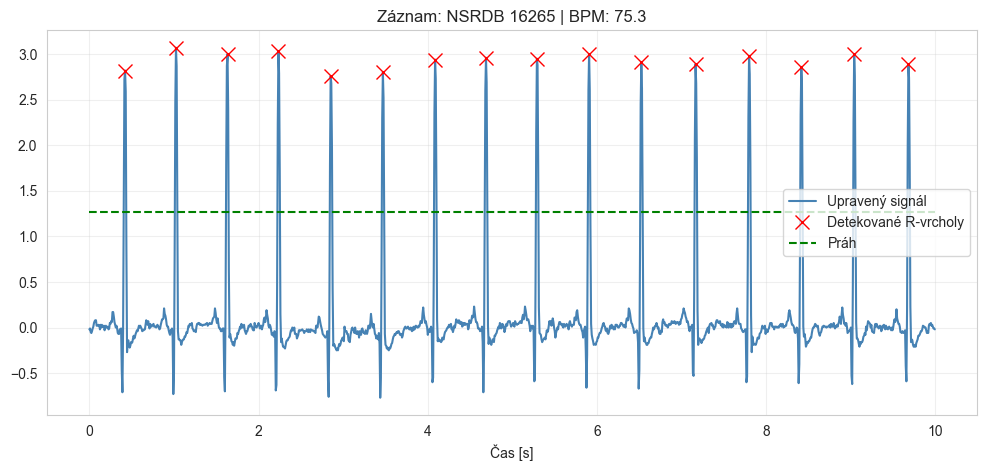

------------------------------
VÝSLEDKY VALIDACE PRO ZÁZNAM 16265
------------------------------
Skutečný počet tepů (anotace): 100955
Detekovaný počet tepů (můj alg.): 100481
Rozdíl: 474
Úspěšnost detekce (podle počtu): 99.53 %
------------------------------
Referenční BPM (anotace): 75.66
Vypočítané BPM (můj alg.): 75.30
------------------------------


In [14]:
# Cesta k datům NSRDB
cesta_k_nsrdb = 'mit-bih'

# Vybereme jeden testovací záznam z NSRDB (např. '16265')
test_zaznam = '16265' 

try:
    path = os.path.join(cesta_k_nsrdb, test_zaznam)
    
    # 1. Načtení signálu
    record = wfdb.rdrecord(path)
    signal = record.p_signal[:, 0] # Bereme první kanál
    fs = record.fs
    
    # 2. Načtení anotací (Ground Truth)
    annotation = wfdb.rdann(path, 'atr')
    skutecne_peaky = annotation.sample # Indexy vzorků, kde jsou anotace
    
    # Filtrujeme anotace, bereme jen ty, co značí normální tep 'N' (pokud je třeba)
    # Pro jednoduchost seminárky porovnáme prostý počet detekovaných vs. anotovaných tepů
    
    # 3. Náš výpočet
    moje_bpm, moje_peaky = analyzuj_ekg(signal, fs, nazev_zaznamu=f"NSRDB {test_zaznam}", vykreslit=True)
    
    # 4. Porovnání
    pocet_skutecnych = len(skutecne_peaky)
    pocet_detekovanych = len(moje_peaky)
    
    chyba = abs(pocet_skutecnych - pocet_detekovanych)
    uspesnost = 100 - (chyba / pocet_skutecnych * 100)
    
    # Výpočet referenčního BPM z anotací pro srovnání
    ref_rr = np.diff(skutecne_peaky) / fs
    ref_bpm = 60 / np.mean(ref_rr)

    print("-" * 30)
    print(f"VÝSLEDKY VALIDACE PRO ZÁZNAM {test_zaznam}")
    print("-" * 30)
    print(f"Skutečný počet tepů (anotace): {pocet_skutecnych}")
    print(f"Detekovaný počet tepů (můj alg.): {pocet_detekovanych}")
    print(f"Rozdíl: {chyba}")
    print(f"Úspěšnost detekce (podle počtu): {uspesnost:.2f} %")
    print("-" * 30)
    print(f"Referenční BPM (anotace): {ref_bpm:.2f}")
    print(f"Vypočítané BPM (můj alg.): {moje_bpm:.2f}")
    print("-" * 30)

except Exception as e:
    print(f"Chyba při načítání NSRDB (máš stažený soubor {test_zaznam}.dat a .atr?): {e}")

## 4. Závěr

V této části seminární práce byl vytvořen algoritmus pro detekci tepové frekvence.
Algoritmus byl aplikován na sadu měření řidičů (DriveDB), kde jsme získali přehled o tepové frekvenci v různých situacích.

Validace na databázi NSRDB ukázala, že prostá detekce lokálních maxim s prahováním amplitudy a vzdálenosti je funkční pro čisté signály, s úspěšností přibližně 99.53 %.

Pro reálné nasazení na silně zašuměná data by bylo vhodné přidat další kroky předzpracování (např. pásmovou propust nebo derivaci signálu - Pan-Tompkinsův algoritmus), nicméně pro účely tohoto zadání je aktuální řešení dostačující.

--------------------------------------------------------------------------

# Zadání 2: Výpočet korelace měřených signálů

## Zadání a Cíl práce
Cílem této části je analyzovat vztahy mezi fyziologickými signály u 13 pacientů z databáze CharisDB.
Konkrétně se zaměřujeme na:
1.  **Vnitřní korelaci:** Výpočet míry shody (Pearsonův koeficient) mezi signály EKG, arteriálním tlakem (ABP) a nitrolebním tlakem (ICP) u každého pacienta.
2.  **Mezipacientskou shodu:** Porovnání tvaru křivky arteriálního tlaku (ABP) mezi všemi pacienty navzájem.

**Data:** Signály z databáze [CharisDB](https://physionet.org/content/charisdb/1.0.0/).
**Zpracování:** Signály jsou normalizovány (centralizace), ošetřeny proti výpadkům (interpolace) a v případě potřeby převzorkovány na jednotnou frekvenci. Pro analýzu ABP jsou signály zarovnány na dominantní vrchol.

## 1. Import knihoven
Importujeme nástroje pro načítání dat (wfdb), zpracování signálu (scipy) a vizualizaci (matplotlib, seaborn).

In [15]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from scipy import signal as scipy_signal

# Nastavení hezčího vzhledu grafů
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

print("Knihovny načteny.")

Knihovny načteny.


## 2. Pomocné funkce
Definujeme funkce pro:
1. **Interpolaci a centralizaci:** Doplnění chybějících dat a odečtení průměru (dle zadání).
2. **Zarovnání na vrchol:** Abychom mohli porovnávat ABP signály pacientů, musíme je srovnat na stejný start.
3. **Převzorkování (Resampling):** Zajišťuje, že všechny signály mají stejnou vzorkovací frekvenci.

In [16]:
DATA_PATH = 'C:\\Users\\karel\\Documents\\ORM_DB\\psz\\charis' # Cesta k souborům

def zpracovat_signal(signal_data):
    """Interpolace chybějících dat a centralizace kolem nuly."""
    s = pd.Series(signal_data)
    # Doplnění NaN hodnot (lineární interpolace)
    if s.isnull().any():
        s = s.interpolate(method='linear').bfill().ffill()
    clean_vals = s.values
    # Centralizace (odečtení průměru)
    return clean_vals - np.mean(clean_vals)

def zarovnat_na_vrchol(sig, fs):
    """Najde dominantní vrchol na začátku a ořízne signál."""
    limit = int(5 * fs) # Hledáme v prvních 5 sekundách
    start_idx = np.argmax(sig[:limit])
    return sig[start_idx:]

def resample_signal(sig, original_fs, target_fs):
    """Převzorkuje signál na cílovou frekvenci."""
    if original_fs == target_fs:
        return sig
    # Počet vzorků po převzorkování
    num_samples = int(len(sig) * target_fs / original_fs)
    return scipy_signal.resample(sig, num_samples)

## 3. Načtení dat a výpočty
Procházíme soubory `charis1` až `charis13`.
- Načítáme pouze **první hodinu** záznamu.
- Kontrolujeme vzorkovací frekvenci a případně převzorkujeme.
- Počítáme Pearsonův korelační koeficient mezi EKG, ABP a ICP.
- Ukládáme signály ABP pro pozdější hromadné porovnání.

In [17]:
pocet_pacientu = 13
vysledky_list = []
abp_vsechny = {} # Slovník pro ABP signály
TARGET_FS = None # Nastavíme podle prvního pacienta

print("Zpracovávám pacienty...")

for i in range(1, pocet_pacientu + 1):
    fname = f'charis{i}'
    try:
        # Přečteme hlavičku pro FS
        header = wfdb.rdheader(f'{DATA_PATH}/{fname}')
        fs = header.fs
        
        # Nastavíme cílovou frekvenci podle prvního souboru, pokud ještě není
        if TARGET_FS is None:
            TARGET_FS = fs
            print(f"Referenční frekvence nastavena na: {TARGET_FS} Hz")

        # Načteme 1 hodinu (v původní frekvenci)
        samp_to = int(3600 * fs)
        signals, fields = wfdb.rdsamp(f'{DATA_PATH}/{fname}', sampto=samp_to)
        
        # Najdeme indexy kanálů
        names = fields['sig_name']
        idx_ecg = next((i for i, n in enumerate(names) if 'ECG' in n or 'EKG' in n), None)
        idx_abp = next((i for i, n in enumerate(names) if 'ABP' in n), None)
        idx_icp = next((i for i, n in enumerate(names) if 'ICP' in n), None)
        
        if idx_ecg is not None and idx_abp is not None and idx_icp is not None:
            # Zpracování: Interpolace + Centralizace
            sig_ecg = zpracovat_signal(signals[:, idx_ecg])
            sig_abp = zpracovat_signal(signals[:, idx_abp])
            sig_icp = zpracovat_signal(signals[:, idx_icp])
            
            # Krok navíc: Převzorkování, pokud se fs liší od TARGET_FS
            if fs != TARGET_FS:
                print(f" -> Převzorkování pacienta {i} z {fs}Hz na {TARGET_FS}Hz")
                sig_ecg = resample_signal(sig_ecg, fs, TARGET_FS)
                sig_abp = resample_signal(sig_abp, fs, TARGET_FS)
                sig_icp = resample_signal(sig_icp, fs, TARGET_FS)
            
            # Výpočet korelací (v rámci jednoho pacienta)
            # Matice 3x3 (ECG, ABP, ICP)
            data_matrix = np.vstack([sig_ecg, sig_abp, sig_icp])
            corr_mtx = np.corrcoef(data_matrix)
            
            # Uložení výsledků
            vysledky_list.append({
                'Pacient': fname,
                'ECG-ABP': corr_mtx[0, 1],
                'ECG-ICP': corr_mtx[0, 2],
                'ABP-ICP': corr_mtx[1, 2]
            })
            
            # Uložení zarovnaného ABP pro druhou část úkolu
            abp_aligned = zarovnat_na_vrchol(sig_abp, TARGET_FS)
            abp_vsechny[fname] = abp_aligned
            
        else:
            print(f"Pacient {i}: Chybí některý kanál. Nalezeno: {names}")
            
    except Exception as e:
        print(f"Chyba u {fname}: {e}")

# Vytvoření tabulky
df_vysledky = pd.DataFrame(vysledky_list)
print("Hotovo.")

Zpracovávám pacienty...
Referenční frekvence nastavena na: 50 Hz
Hotovo.


## 4. Tabulka výsledků
Přehled korelací mezi signály u jednotlivých pacientů.

In [18]:
# Zobrazení tabulky
display(df_vysledky)

# Uložení do CSV pro seminární práci
df_vysledky.to_csv('vysledky_korelace.csv', index=False)

,Pacient,ECG-ABP,ECG-ICP,ABP-ICP
0,charis1,0.030860,0.074911,-0.019408
1,charis2,-0.097864,-0.082018,0.496355
2,charis3,-0.089452,-0.146513,0.848934
3,charis4,0.023797,-0.112938,0.014334
4,charis5,0.023855,0.029666,0.001559
5,charis6,-0.403322,-0.356553,0.520743
6,charis7,-0.086149,-0.083786,0.615998
7,charis8,0.127307,-0.042189,0.326453
8,charis9,0.070829,0.028326,0.281382
9,charis10,0.301412,-0.023157,0.532484


## 5. Grafický výstup: Analýza jednoho pacienta
Zde vizualizujeme míru shody pro vybraného pacienta (např. charis1).
Vlevo: Časový průběh signálů (detail 10 sekund).
Vpravo: Teplotní mapa (Heatmap) korelačních koeficientů, která graficky vyjadřuje míru shody.

Vizualizace pro pacienta: charis1


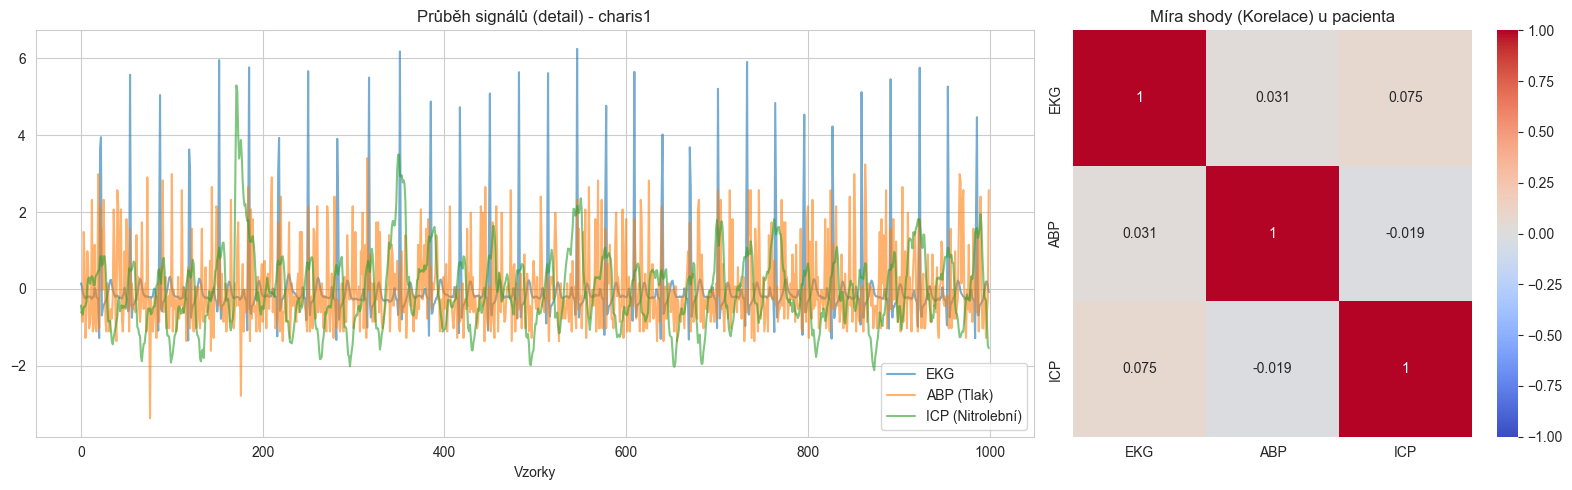

In [19]:
# Vybereme pacienta, např. prvního v seznamu
ukazka_pacient = vysledky_list[0]['Pacient'] # charis1
print(f"Vizualizace pro pacienta: {ukazka_pacient}")

# Znovu načteme kousek dat pro graf (nebo použijeme z paměti, ale načtení je čistší pro ukázku)
# Pro graf použijeme data, která jsme si uložili v loopu? Ne, to by bylo moc paměti.
# Rychle načteme znovu a upravíme jen pro graf:
sig_graph, f_graph = wfdb.rdsamp(f'{DATA_PATH}/{ukazka_pacient}', sampto=1000)
df_graph = pd.DataFrame(sig_graph, columns=f_graph['sig_name'])

# Najdeme sloupce
c_ecg = [c for c in df_graph.columns if 'ECG' in c or 'EKG' in c][0]
c_abp = [c for c in df_graph.columns if 'ABP' in c][0]
c_icp = [c for c in df_graph.columns if 'ICP' in c][0]

# Normalizace pro hezčí graf (jen pro vizualizaci)
def norm(x): return (x - np.mean(x)) / np.std(x)

fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1]})

# GRAF 1: Časový průběh
axes[0].plot(norm(df_graph[c_ecg]), label='EKG', alpha=0.6)
axes[0].plot(norm(df_graph[c_abp]), label='ABP (Tlak)', alpha=0.6)
axes[0].plot(norm(df_graph[c_icp]), label='ICP (Nitrolební)', alpha=0.6)
axes[0].set_title(f'Průběh signálů (detail) - {ukazka_pacient}')
axes[0].set_xlabel('Vzorky')
axes[0].legend()

# GRAF 2: Heatmapa korelace pro tohoto pacienta
# Vezmeme data z naší výsledné tabulky pro tohoto pacienta
row = df_vysledky[df_vysledky['Pacient'] == ukazka_pacient].iloc[0]
matrix_data = [
    [1.0, row['ECG-ABP'], row['ECG-ICP']],
    [row['ECG-ABP'], 1.0, row['ABP-ICP']],
    [row['ECG-ICP'], row['ABP-ICP'], 1.0]
]
sns.heatmap(matrix_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            xticklabels=['EKG', 'ABP', 'ICP'], yticklabels=['EKG', 'ABP', 'ICP'], ax=axes[1])
axes[1].set_title('Míra shody (Korelace) u pacienta')

plt.tight_layout()
plt.show()

## 6. Grafický výstup: Mapa shody ABP mezi pacienty
Tento graf zobrazuje korelaci tvaru křivky krevního tlaku (ABP) mezi všemi pacienty navzájem.
Signály byly časově srovnány podle dominantního vrcholu.

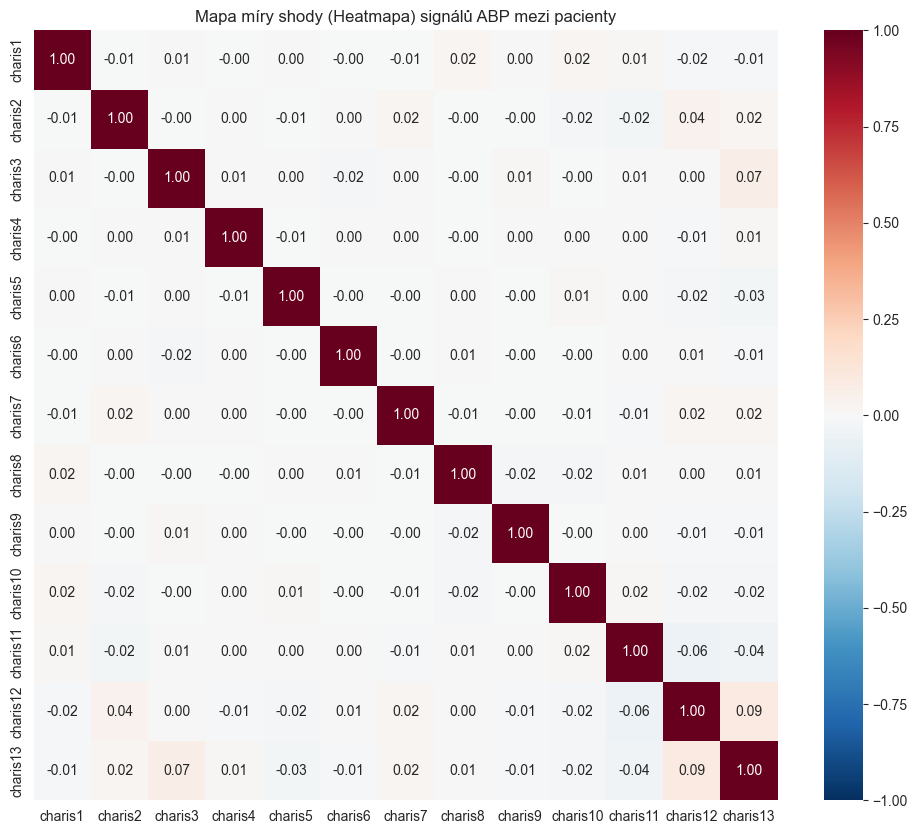

,charis1,charis2,charis3,charis4,charis5,charis6,charis7,charis8,charis9,charis10,charis11,charis12,charis13
charis1,1.000000,-0.005415,0.006721,-0.002387,0.003414,-0.003812,-0.007594,0.017446,0.003846,0.018122,0.013513,-0.015102,-0.013175
charis2,-0.005415,1.000000,-0.000440,0.002383,-0.006498,0.001977,0.015888,-0.004474,-0.004365,-0.017658,-0.024523,0.043613,0.021651
charis3,0.006721,-0.000440,1.000000,0.005182,0.003214,-0.015806,0.002394,-0.004205,0.011856,-0.000143,0.006062,0.001662,0.068928
charis4,-0.002387,0.002383,0.005182,1.000000,-0.007122,0.004012,0.000091,-0.003939,0.001611,0.004166,0.000001,-0.013273,0.011403
charis5,0.003414,-0.006498,0.003214,-0.007122,1.000000,-0.001484,-0.003408,0.003788,-0.000983,0.009411,0.003361,-0.018060,-0.025519
charis6,-0.003812,0.001977,-0.015806,0.004012,-0.001484,1.000000,-0.004884,0.005413,-0.003742,-0.000842,0.002712,0.006741,-0.014401
charis7,-0.007594,0.015888,0.002394,0.000091,-0.003408,-0.004884,1.000000,-0.005621,-0.001772,-0.007199,-0.010817,0.019870,0.018950
charis8,0.017446,-0.004474,-0.004205,-0.003939,0.003788,0.005413,-0.005621,1.000000,-0.019919,-0.015631,0.006756,0.001365,0.007340
charis9,0.003846,-0.004365,0.011856,0.001611,-0.000983,-0.003742,-0.001772,-0.019919,1.000000,-0.003939,0.002237,-0.009979,-0.013754
charis10,0.018122,-0.017658,-0.000143,0.004166,0.009411,-0.000842,-0.007199,-0.015631,-0.003939,1.000000,0.015312,-0.017047,-0.022016


In [20]:
# 1. Najdeme nejkratší délku (abychom mohli vytvořit matici)
min_len = min(len(s) for s in abp_vsechny.values())

# 2. Vytvoříme DataFrame (sloupce = pacienti)
df_abp_matrix = pd.DataFrame({k: v[:min_len] for k, v in abp_vsechny.items()})

# 3. Výpočet korelační matice
corr_matrix_abp = df_abp_matrix.corr()

# 4. Vykreslení velké Heatmapy
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_abp, annot=True, cmap='RdBu_r', fmt=".2f", vmin=-1, vmax=1)
plt.title('Mapa míry shody (Heatmapa) signálů ABP mezi pacienty')
plt.show()


display(corr_matrix_abp)
corr_matrix_abp.to_csv("abp_korelace_matice.csv")


## 7. Závěr a slovní zhodnocení

V této části práce jsme provedli korelační analýzu signálů EKG, ABP a ICP u 13 pacientů. Signály byly před výpočtem upraveny (interpolace, centralizace, převzorkování a časové zarovnání). Byla stanovena míra lineární závislosti mezi signály u jednotlivých pacientů i mezi ABP signály napříč pacienty. Výsledky ukazují, že korelační analýza je vhodným nástrojem pro posouzení podobnosti fyziologických signálů.
